<a href="https://colab.research.google.com/github/zec1616/cyngua/blob/main/problem_set4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1a:

def align(seq1, seq2, match=1, gap_penalty=1, mismatch_penalty=1):

    # Initialize the scoring matrix
    rows, cols = len(seq1) + 1, len(seq2) + 1
    matrix = [[0 for j in range(cols)] for i in range(rows)]
    backtrack = [[None for j in range(cols)] for i in range(rows)]

    # Fill the scoring matrix
    max_score = 0
    max_pos = (0, 0)

    for i in range(1, rows):
        for j in range(1, cols):
            # Calculate scores for all possible moves
            diagonal = matrix[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else -mismatch_penalty)
            up = matrix[i-1][j] - gap_penalty
            left = matrix[i][j-1] - gap_penalty

            # Take the maximum score, but not less than 0 (local alignment)
            matrix[i][j] = max(0, diagonal, up, left)

            # Store the backtracking information
            if matrix[i][j] == 0:
                backtrack[i][j] = 'end'
            elif matrix[i][j] == diagonal:
                backtrack[i][j] = 'diagonal'
            elif matrix[i][j] == up:
                backtrack[i][j] = 'up'
            else:
                backtrack[i][j] = 'left'

            # Update maximum score position
            if matrix[i][j] > max_score:
                max_score = matrix[i][j]
                max_pos = (i, j)

    # Backtrack to find the alignment
    aligned1 = []
    aligned2 = []
    i, j = max_pos

    while matrix[i][j] > 0:
        if backtrack[i][j] == 'diagonal':
            aligned1.append(seq1[i-1])
            aligned2.append(seq2[j-1])
            i -= 1
            j -= 1
        elif backtrack[i][j] == 'up':
            aligned1.append(seq1[i-1])
            aligned2.append('-')
            i -= 1
        else:  # left
            aligned1.append('-')
            aligned2.append(seq2[j-1])
            j -= 1

    # Reverse the alignments (since we backtracked)
    aligned1 = ''.join(reversed(aligned1))
    aligned2 = ''.join(reversed(aligned2))

    return aligned1, aligned2, max_score

In [2]:
# 1b

def run_test(seq1, seq2, match=1, gap_penalty=1, mismatch_penalty=1, description=""):
    result = align(seq1, seq2, match, gap_penalty, mismatch_penalty)
    print(f"\nTest: {description}")
    print(f"Parameters: match={match}, gap_penalty={gap_penalty}, mismatch_penalty={mismatch_penalty}")
    print(f"Sequence 1: {seq1}")
    print(f"Sequence 2: {seq2}")
    print(f"Aligned 1:  {result[0]}")
    print(f"Aligned 2:  {result[1]}")
    print(f"Score:      {result[2]}")
    return result

# Test 1: Original example from the problem
test1 = run_test(
    'tgcatcgagaccctacgtgac',
    'actagacctagcatcgac',
    description="Original example with default parameters"
)

# Test 2: Original example with higher gap penalty
test2 = run_test(
    'tgcatcgagaccctacgtgac',
    'actagacctagcatcgac',
    gap_penalty=2,
    description="Original example with gap_penalty=2"
)

# Test 3: Short sequences with higher match score
test3 = run_test(
    'ATCG',
    'TCG',
    match=2,
    description="Short sequences with higher match score"
)

# Test 4: Test with higher mismatch penalty
test4 = run_test(
    'ATCGAT',
    'ATACAT',
    mismatch_penalty=2,
    description="Testing higher mismatch penalty"
)

# Test 5: Test with no matching characters
test5 = run_test(
    'AAAA',
    'TTTT',
    description="Sequences with no matches"
)

# Test 6: Test with identical sequences
test6 = run_test(
    'ATCG',
    'ATCG',
    description="Identical sequences"
)

# Test 7: Test with very different scoring scheme
test7 = run_test(
    'ATCGAT',
    'ATCG',
    match=3,
    gap_penalty=2,
    mismatch_penalty=3,
    description="Test with very different scoring scheme"
)


Test: Original example with default parameters
Parameters: match=1, gap_penalty=1, mismatch_penalty=1
Sequence 1: tgcatcgagaccctacgtgac
Sequence 2: actagacctagcatcgac
Aligned 1:  agacccta-cgt-gac
Aligned 2:  aga-cctagcatcgac
Score:      8

Test: Original example with gap_penalty=2
Parameters: match=1, gap_penalty=2, mismatch_penalty=1
Sequence 1: tgcatcgagaccctacgtgac
Sequence 2: actagacctagcatcgac
Aligned 1:  gcatcga
Aligned 2:  gcatcga
Score:      7

Test: Short sequences with higher match score
Parameters: match=2, gap_penalty=1, mismatch_penalty=1
Sequence 1: ATCG
Sequence 2: TCG
Aligned 1:  TCG
Aligned 2:  TCG
Score:      6

Test: Testing higher mismatch penalty
Parameters: match=1, gap_penalty=1, mismatch_penalty=2
Sequence 1: ATCGAT
Sequence 2: ATACAT
Aligned 1:  AT-CGAT
Aligned 2:  ATAC-AT
Score:      3

Test: Sequences with no matches
Parameters: match=1, gap_penalty=1, mismatch_penalty=1
Sequence 1: AAAA
Sequence 2: TTTT
Aligned 1:  
Aligned 2:  
Score:      0

Test: Identic

In [3]:
# 2a

import math
from collections import Counter

class QuadTreeNode:
    def __init__(self, x_min, x_max, y_min, y_max):
        """
        Initialize a QuadTree node with given boundary coordinates.
        Nodes store points and can have up to 4 children.
        """
        self.bounds = (x_min, x_max, y_min, y_max)  # Boundary of the node
        self.points = []  # Points stored in this node
        self.children = [None, None, None, None]  # Child nodes (subdivisions)

    def is_leaf(self):
        """
        Check if the node is a leaf (has no children).
        """
        return all(child is None for child in self.children)

    def subdivide(self):
        """
        Subdivide the current node into four child nodes (quadrants).
        """
        x_min, x_max, y_min, y_max = self.bounds
        x_mid = (x_min + x_max) / 2
        y_mid = (y_min + y_max) / 2

        # Create 4 quadrants: bottom-left, bottom-right, top-left, top-right
        self.children[0] = QuadTreeNode(x_min, x_mid, y_min, y_mid)  # Bottom-left
        self.children[1] = QuadTreeNode(x_mid, x_max, y_min, y_mid)  # Bottom-right
        self.children[2] = QuadTreeNode(x_min, x_mid, y_mid, y_max)  # Top-left
        self.children[3] = QuadTreeNode(x_mid, x_max, y_mid, y_max)  # Top-right

    def insert(self, point):
        """
        Insert a point into the QuadTree. Points are stored in leaf nodes.
        """
        x, y, _ = point  # Unpack the point (x, y, class)

        # If the node can store more points, add the point directly
        if len(self.points) < 4:
            self.points.append(point)
        else:
            # If the node is full, subdivide and delegate insertion to children
            if self.is_leaf():
                self.subdivide()

            # Determine which child should store the point based on its position
            x_min, x_max, y_min, y_max = self.bounds
            x_mid = (x_min + x_max) / 2
            y_mid = (y_min + y_max) / 2

            # Determine the appropriate quadrant
            idx = (x >= x_mid) + 2 * (y >= y_mid)  # Maps to child index
            self.children[idx].insert(point)

    def query(self, x, y, k):
        """
        Query the k-nearest neighbors to a given (x, y) point.
        Uses Euclidean distance to find the closest neighbors.
        """
        nearest = []  # List to store nearest neighbors (distance, point)

        def distance(p1, p2):
            """
            Calculate Euclidean distance between two points.
            """
            return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

        def search(node):
            """
            Recursive search through the QuadTree to find nearest neighbors.
            """
            if node is None:
                return  # Base case: stop if node is empty

            # Check if the current node is a leaf
            if node.is_leaf():
                # Compute the distance for each point in the leaf
                for p in node.points:
                    d = distance((x, y), p)
                    nearest.append((d, p))
                    # Keep only the k smallest distances
                    nearest.sort(key=lambda x: x[0])
                    if len(nearest) > k:
                        nearest.pop()  # Remove the farthest point if > k neighbors
            else:
                # Search through child nodes recursively
                for child in node.children:
                    if child:
                        search(child)

        search(self)  # Start the search from the root node
        # Return the k nearest points sorted by distance
        return [p for _, p in sorted(nearest, key=lambda x: x[0])[:k]]

class QuadTreeKNN:
    def __init__(self, x_min, x_max, y_min, y_max):
        """
        Initialize the QuadTree-based k-Nearest Neighbors classifier.
        """
        self.root = QuadTreeNode(x_min, x_max, y_min, y_max)

    def fit(self, data):
        """
        Fit the model by inserting data points into the QuadTree.
        """
        for point in data:
            self.root.insert(point)

    def predict(self, x, y, k):
        """
        Predict the class of a new point by finding its k-nearest neighbors.
        """
        # Query the k-nearest neighbors
        nearest_neighbors = self.root.query(x, y, k)
        # Extract the classes of the neighbors
        classes = [point[2] for point in nearest_neighbors]
        # Find the most common class
        most_common_class = Counter(classes).most_common(1)[0][0]
        return most_common_class, nearest_neighbors


In [4]:
# 2b

#Test dataset: (x, y, class)

data = [
    (1, 2, 'A'),
    (2, 3, 'A'),
    (3, 4, 'B'),
    (6, 5, 'B'),
    (7, 8, 'C'),
    (8, 9, 'C'),
    (10, 10, 'A'),
]

# Initialize and train the QuadTreeKNN classifier
knn = QuadTreeKNN(x_min=0, x_max=12, y_min=0, y_max=12)
knn.fit(data)

# Predict the class for a new point (5, 5) with k=3
x, y, k = 5, 5, 3
predicted_class, neighbors = knn.predict(x, y, k)

print("Predicted Class:", predicted_class)
print("Nearest Neighbors:", neighbors)

# Predict with a different value of k
k = 5
predicted_class, neighbors = knn.predict(x, y, k)
print("\nWith k=5:")
print("Predicted Class:", predicted_class)
print("Nearest Neighbors:", neighbors)


Predicted Class: C
Nearest Neighbors: [(7, 8, 'C'), (8, 9, 'C'), (10, 10, 'A')]

With k=5:
Predicted Class: C
Nearest Neighbors: [(7, 8, 'C'), (8, 9, 'C'), (10, 10, 'A')]


In [5]:
!pip install openpyxl


In [6]:
# 2c
import pandas as pd

data = pd.read_excel('sample_data/Rice_Cammeo_Osmancik.xlsx')

quantitative_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Normalize the columns to mean = 0 and standard deviation = 1
data[quantitative_columns] = (data[quantitative_columns] - data[quantitative_columns].mean()) / data[quantitative_columns].std()

# Print the normalized data to confirm
print(data.head())

       Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  1.479635   2.004091           2.348238          -0.212915      2.018073   
1  1.147720   1.125705           0.988261           0.945444      0.409964   
2  1.135020   1.317041           1.451718           0.253854      1.212797   
3  0.293398   0.115285           0.261405           0.198025      0.239720   
4  1.166191   1.486858           1.316269           0.523351      0.952096   

   Convex_Area    Extent   Class  
0     1.499463 -1.152770  Cammeo  
1     1.192761 -0.602000  Cammeo  
2     1.126356  0.405558  Cammeo  
3     0.233826 -0.275315  Cammeo  
4     1.299685 -0.205986  Cammeo  


In [7]:
# 2d

from sklearn import decomposition

# Assuming the normalized dataset is already available as 'data'

# Specify the columns to perform PCA on (all numeric columns except for class labels)
my_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Perform PCA
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(data[my_cols])

# Extract principal components
pc0 = data_reduced[:, 0]  # First principal component (x-values)
pc1 = data_reduced[:, 1]  # Second principal component (y-values)

# Assuming "CLASS" is the column indicating the type of rice
class_labels = data["Class"]

# Display results
print("First Principal Component (PC0):", pc0)
print("Second Principal Component (PC1):", pc1)
print("Class Labels:", class_labels.unique())



First Principal Component (PC0): [ 3.81212784  2.47683257  2.63820924 ... -0.43662669 -3.58746234
 -2.55575212]
Second Principal Component (PC1): [ 2.16504685 -0.04529019  0.62153372 ... -0.10358082  0.37565233
 -3.36079599]
Class Labels: ['Cammeo' 'Osmancik']


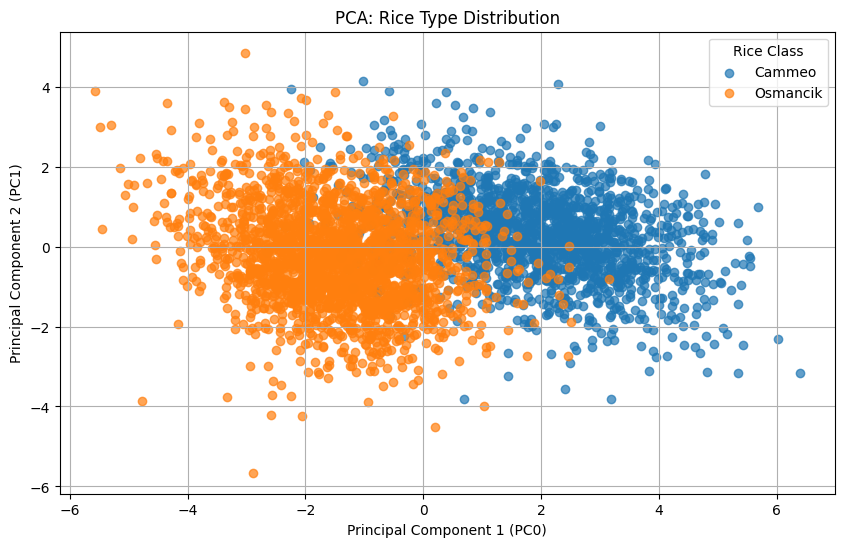

In [8]:
# 2e

import matplotlib.pyplot as plt

# Scatterplot of PCA results
plt.figure(figsize=(10, 6))
unique_classes = class_labels.unique()

# Color-code by class
for rice_class in unique_classes:
    indices = class_labels == rice_class
    plt.scatter(pc0[indices], pc1[indices], label=rice_class, alpha=0.7)

# Add labels and legend
plt.xlabel("Principal Component 1 (PC0)")
plt.ylabel("Principal Component 2 (PC1)")
plt.title("PCA: Rice Type Distribution")
plt.legend(title="Rice Class")
plt.grid(True)

# Show plot
plt.show()


# 2f

1: In areas where the points form well-separated clusters, k-nearest neighbours is likely to perform well. These regions represent data points where the nearest neighbors predominantly belong to the same class.

2: The significant overlap in the middle of the graph suggests that k-nearest neighbours may struggle to accurately classify points in this region. Points in these overlapping areas are likely to have nearest neighbors from both classes, leading to potential misclassification.

3: Reducing the data to two dimensions using PCA has preserved much of the separability between the classes. This suggests that the key variance in the original dataset is effectively captured, making k-nearest neighbours a viable method.

In [9]:
# 2g

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Assuming `pc0`, `pc1`, and `class_labels` are already defined
# Combine PCA results into a DataFrame
X = pd.DataFrame({'PC0': pc0, 'PC1': pc1})  # Principal components
y = class_labels  # Class labels (rice types)

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the k-NN classifier with k=1
knn = KNeighborsClassifier(n_neighbors=1)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[448  70]
 [ 55 570]]

Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.89      0.86      0.88       518
    Osmancik       0.89      0.91      0.90       625

    accuracy                           0.89      1143
   macro avg       0.89      0.89      0.89      1143
weighted avg       0.89      0.89      0.89      1143



In [10]:
# 2h
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd


# Combine PCA results into a DataFrame
X = pd.DataFrame({'PC0': pc0, 'PC1': pc1})  # Principal components
y = class_labels  # Class labels (rice types)

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize k-NN classifier with k=5
knn_k5 = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn_k5.fit(X_train, y_train)

# Make predictions on the test set for k=5
y_pred_k5 = knn_k5.predict(X_test)

# Generate confusion matrix for k=5
conf_matrix_k5 = confusion_matrix(y_test, y_pred_k5)

# Display confusion matrix and classification report for k=5
print("Confusion Matrix for k=5:")
print(conf_matrix_k5)

print("\nClassification Report for k=5:")
print(classification_report(y_test, y_pred_k5))



Confusion Matrix for k=5:
[[464  54]
 [ 49 576]]

Classification Report for k=5:
              precision    recall  f1-score   support

      Cammeo       0.90      0.90      0.90       518
    Osmancik       0.91      0.92      0.92       625

    accuracy                           0.91      1143
   macro avg       0.91      0.91      0.91      1143
weighted avg       0.91      0.91      0.91      1143



2i:

For k=1
True Positives (TP): 448
False Positives (FP): 70
False Negatives (FN): 55
True Negatives (TN): 570

For k=5
True Positives (TP): 464
False Positives (FP): 54
False Negatives (FN): 49
True Negatives (TN): 576


So, increasing k to 5 leads to better classification performance, as it reduces the impact of noisy or outlier points.

K=5 achieves a better balance between true positives and false positives/negatives, making it a more robust choice for this dataset.


Calculation took 30.19 seconds


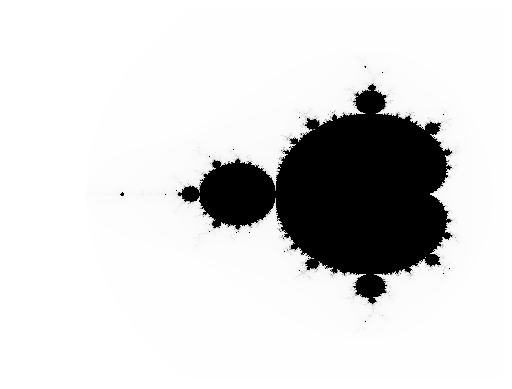

In [11]:
# 3: mandelbrot_set.py

import matplotlib.pyplot as plt
import numpy
import time

# Define the Mandelbrot set parameters
xlo = -2.5
ylo = -1.5
xhi = 0.75
yhi = 1.5
nx = 2048
ny = 1536
dx = (xhi - xlo) / nx
dy = (yhi - ylo) / ny
iter_limit = 200
set_threshold = 2

# Function to test if a point is in the Mandelbrot set
def mandelbrot_test(x, y):
    z = 0
    c = x + y * 1j
    for i in range(iter_limit):
        z = z ** 2 + c
        if abs(z) > set_threshold:
            return i
    return i

# Function to calculate the Mandelbrot set
def calculate_set():
    result = numpy.zeros([ny, nx])
    for i in range(ny):
        y = i * dy + ylo
        for j in range(nx):
            x = j * dx + xlo
            result[i, j] = mandelbrot_test(x, y)
    return result

# Main block to calculate and display the Mandelbrot set
if __name__ == "__main__":
    start_time = time.perf_counter()
    mandelbrot_set = calculate_set()
    stop_time = time.perf_counter()
    print(f"Calculation took {stop_time - start_time:.2f} seconds")

    # Display the Mandelbrot set
    plt.imshow(mandelbrot_set, interpolation="nearest", cmap="Greys")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.show()


In [38]:
!apt-get install -y mpich
!pip install mpi4py



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mpich is already the newest version (4.0-3).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


Parallel computation with 1 processes took 30.71 seconds
Running sequential computation for validation...
Sequential computation took 34.56 seconds
Validation successful: Parallel computation matches sequential computation.


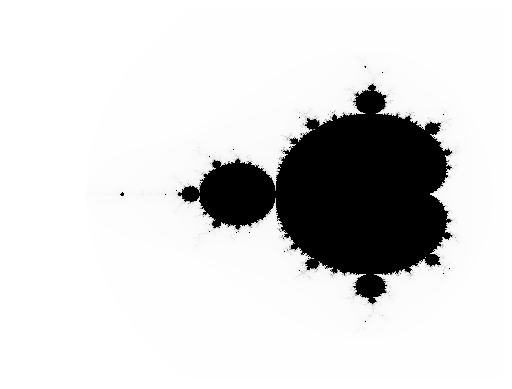

In [39]:
# 3 - parallel version

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import time

# Define the Mandelbrot set parameters
xlo = -2.5
ylo = -1.5
xhi = 0.75
yhi = 1.5
nx = 2048
ny = 1536
dx = (xhi - xlo) / nx
dy = (yhi - ylo) / ny
iter_limit = 200
set_threshold = 2

# Function to test if a point is in the Mandelbrot set
def mandelbrot_test(x, y):
    z = 0
    c = x + y * 1j
    for i in range(iter_limit):
        z = z ** 2 + c
        if abs(z) > set_threshold:
            return i
    return i

# Function to calculate a portion of the Mandelbrot set
def calculate_partial_set(start_row, end_row):
    partial_result = np.zeros((end_row - start_row, nx))
    for i in range(start_row, end_row):
        y = i * dy + ylo
        for j in range(nx):
            x = j * dx + xlo
            partial_result[i - start_row, j] = mandelbrot_test(x, y)
    return partial_result

# Main parallel block
if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Divide the workload: calculate start and end rows for each process
    rows_per_process = ny // size
    start_row = rank * rows_per_process
    end_row = start_row + rows_per_process if rank != size - 1 else ny

    # Start timing
    start_time = MPI.Wtime()

    # Each process computes its portion of the Mandelbrot set
    partial_set = calculate_partial_set(start_row, end_row)

    # Gather results at the root process
    if rank == 0:
        mandelbrot_set = np.zeros((ny, nx))
    else:
        mandelbrot_set = None

    # Gather all rows to the root process
    comm.Gather(partial_set, mandelbrot_set, root=0)

    # End timing
    end_time = MPI.Wtime()
    if rank == 0:
        print(f"Parallel computation with {size} processes took {end_time - start_time:.2f} seconds")

        # Sequential computation for validation
        print("Running sequential computation for validation...")
        seq_start_time = time.perf_counter()
        sequential_set = calculate_partial_set(0, ny)
        seq_end_time = time.perf_counter()
        print(f"Sequential computation took {seq_end_time - seq_start_time:.2f} seconds")

        # Compare results
        if np.array_equal(mandelbrot_set, sequential_set):
            print("Validation successful: Parallel computation matches sequential computation.")
        else:
            print("Validation failed: Parallel computation does not match sequential computation.")

        # Display the Mandelbrot set
        plt.imshow(mandelbrot_set, interpolation="nearest", cmap="Greys")
        plt.gca().set_aspect("equal")
        plt.axis("off")
        plt.show()

In [36]:
!mpiexec --allow-run-as-root --oversubscribe -np 2 python parallel_mandelbrot.py


In [37]:
!mpiexec --allow-run-as-root --oversubscribe -np 2 python parallel_mandelbrot.py



Changes: I split the computation into chunks (rows of the Mandelbrot set) and assigned these to MPI processes, using MPI.COMM_WORLD to distribute tasks and gather results.

Limitations:

Memory Concern:

Having all the Mandelbrot calculations come together in one central process could overload the system when working with high-resolution images. Also, the solution could be to either store the data across multiple files or combine the results gradually instead.

Performance Limitation:

The workload is statically divided among processes. For areas with higher computational demand (e.g., points near the set's boundary), dynamic workload distribution could improve efficiency.

